In [1]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.8 MB/s eta 0:00:00


In [2]:
DATA_PATH = '/kaggle/input/deepfakeseqdataset/'

In [3]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter, defaultdict
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
df = pd.read_csv(DATA_PATH + 'faces_metadata.csv')
df

,file_path,label
0,deepfake-detection/FAKE/FAKE/dfdc_train_part_9...,FAKE
1,deepfake-detection/FAKE/FAKE/dfdc_train_part_4...,FAKE
2,deepfake-detection/FAKE/FAKE/dfdc_train_part_1...,FAKE
3,deepfake-detection/FAKE/FAKE/dfdc_train_part_8...,FAKE
4,deepfake-detection/FAKE/FAKE/dfdc_train_part_1...,FAKE
...,...,...
4440,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL
4441,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL
4442,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL
4443,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL


In [7]:
!ls /kaggle/input/

deepfakeseqdataset  stepdata20


In [8]:
def convert_path(path: str) -> str:
    for i in range(10):
        path = path.replace(f'{i:02}', str(i))
    return path


def process_file_paths(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((DATA_PATH + file_path, row['label']))

    return result


def get_video_info(video_path: str) -> Union[Tuple[int, float], Tuple[None, None]]:
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Не вдалося відкрити файл: {video_path}")
        return None, None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)  
    cap.release()
    
    return frame_count, fps

In [9]:
video_stats = []
result = process_file_paths(df)

for video_path, label in result:
    frame_count, fps = get_video_info(video_path)
    if frame_count is not None and fps is not None:
        video_stats.append({
            'file_path': video_path,
            'label': label,
            'frames': frame_count,
            'fps': fps
        })

df = pd.DataFrame(video_stats)

stats_fps = df['fps'].describe()
stats_frames = df['frames'].describe()

print("FPS статистика:")
print(stats_fps)

print("\nКількість кадрів статистика:")
print(stats_frames)
#df = df[df['fps'] >= 28]

FPS статистика:
count    4445.000000
mean       28.551856
std         1.691250
min        12.000000
25%        29.000000
50%        29.000000
75%        29.000000
max        30.000000
Name: fps, dtype: float64

Кількість кадрів статистика:
count    4445.0
mean       60.0
std         0.0
min        60.0
25%        60.0
50%        60.0
75%        60.0
max        60.0
Name: frames, dtype: float64


In [10]:
files_to_remove_unique = set(['avjwhrqbwl_0', 'bpqrwvichd_0', 'cctrhqvein_0', 'eupisnxhsb_0', 'gerhijzwvq_0', 'katmliewya_0', 'onoowfeded_0',
                  'pydbvfkslp_0', 'qqisdvvgfi_0', 'sclvdumbkh_0', 'snphlfsrmr_0', 'spxqkpmopb_0', 'vugbaeziku_0', 'vvtcvjvkqx_0',
                   'xuoqfchsfj_0', 'zdkyyawcwe_0', 'mshechsves_0', 'ejwvqbeyef_0', 'pqbyjmgmrk_0', 'drmtykanjz_0', 'fktxniwzxe_0',
                   'iynuflmhau_0', 'kligyzlcuk_0', 'kifzxbsnku_0', 'kifzxbsnku_0', 'euarbrmuzs_0', 'fodhjwybqm_0', 'pbpgyiimwt_0',
                   'qmqfqyqmfx_0', 'thmwcolqan_0', 'xhwacojjdg_0', 'xkwjjjkcam_0', 'zktuaqrqqv_0', 'cioizeilvz_0', 'cotvlcroov_0',
                   'tuxbzsrszr_0', 'ynpqkrmuap_0', 'gomxkjifiu_0', 'ukrckkvaqi_0', 'vlcbaytswm_0', 'wmobvmntzu_0', 'ydqeopjemz_0',
                   'cxfbhgmuyu_0', 'hqqmtxvbjj_0', 'jaetnqgktl_0', 'yurtzoovou_0', 'hlcqjuwpsd_0', 'iarobzzslu_0', 'ailmasxkxb_0',
                   'bbwrqfawrj_0', 'cefzoeryat_0', 'egcuyhyvsm_0', 'eqgipviesf_0', 'fwekcrqdak_0', 'giqncczwue_0', 'hslupphtel_0',
                   'jmqmljznhv_0', 'lkbpavasad_0', 'osqruujwxd_0', 'pjibpowymk_0', 'ptchnzeeqc_0', 'sppyyoqaey_0', 'tohrqjyter_0',
                   'xzcexrifxq_0', 'aahncigwte_0', 'fszexmwczt_0', 'fszexmwczt_0', 'lkgrqfcrps_0', 'cdgrttukjn_0', 'eclxonfxph_0',
                   'eclxonfxph_0', 'gzbagbdubm_0', 'hhhvnhhqsc_0', 'junllgghcq_0', 'qyefejorlb_0'
                  ])
files_to_remove = list(files_to_remove_unique)
#df = df[~df['file_path'].apply(lambda x: any(file in x for file in files_to_remove))]
#df

In [11]:
def df_to_list(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((file_path, row['label']))

    return result


result = df_to_list(df)
#result

In [12]:
groups = defaultdict(list)
for file_path, label in result:
    base_name = os.path.basename(file_path).split('_')[0]
    groups[base_name].append((file_path, label))

single_element_groups = [group for group in groups.values() if len(group) == 1]

#single_element_groups


In [13]:
train_files = [item for group in single_element_groups for item in group]

In [14]:
#train_files

In [15]:
df = pd.DataFrame(train_files, columns=['video_path', 'label'])
#real_videos = df[df['label'] == 'REAL']
#fake_videos = df[df['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#df = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)

train_data = df[~df['video_path'].str.contains('dfdc_train_part_8')]
test_data = df[df['video_path'].str.contains('dfdc_train_part_8')]

In [16]:
for i in range(10):
    subset_df = df[df['video_path'].str.contains(f'dfdc_train_part_{i}')]
    label_distribution = subset_df['label'].value_counts()
    print(i)
    print(label_distribution)

0
label
FAKE    150
REAL     70
Name: count, dtype: int64
1
label
FAKE    224
REAL    105
Name: count, dtype: int64
2
label
REAL    211
FAKE    164
Name: count, dtype: int64
3
label
REAL    200
FAKE    170
Name: count, dtype: int64
4
label
FAKE    170
REAL    161
Name: count, dtype: int64
5
label
REAL    320
FAKE    249
Name: count, dtype: int64
6
label
FAKE    393
REAL    391
Name: count, dtype: int64
7
label
REAL    310
FAKE    270
Name: count, dtype: int64
8
label
REAL    255
FAKE    215
Name: count, dtype: int64
9
label
REAL    262
FAKE    155
Name: count, dtype: int64


In [17]:
#train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=17)

print("Train set size:", len(train_data))
print("Test set size:", len(test_data))

Train set size: 3975
Test set size: 470


In [18]:
test_data

,video_path,label
3,/kaggle/input/deepfakeseqdataset/deepfake-dete...,FAKE
14,/kaggle/input/deepfakeseqdataset/deepfake-dete...,FAKE
31,/kaggle/input/deepfakeseqdataset/deepfake-dete...,FAKE
35,/kaggle/input/deepfakeseqdataset/deepfake-dete...,FAKE
42,/kaggle/input/deepfakeseqdataset/deepfake-dete...,FAKE
...,...,...
4178,/kaggle/input/deepfakeseqdataset/deepfake-dete...,REAL
4179,/kaggle/input/deepfakeseqdataset/deepfake-dete...,REAL
4180,/kaggle/input/deepfakeseqdataset/deepfake-dete...,REAL
4181,/kaggle/input/deepfakeseqdataset/deepfake-dete...,REAL


In [19]:
#real_videos = train_data[train_data['label'] == 'REAL']
#fake_videos = train_data[train_data['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#train_data = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)
#train_data

<Axes: >

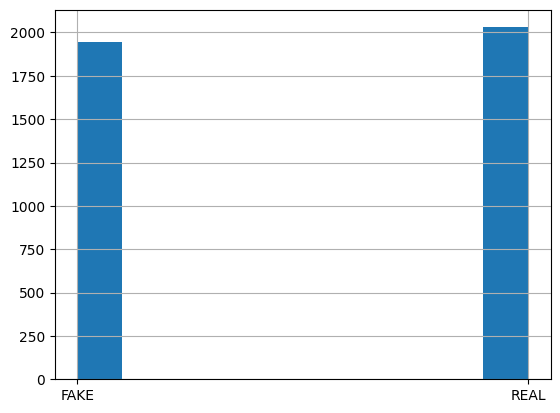

In [20]:
train_data['label'].hist()

<Axes: >

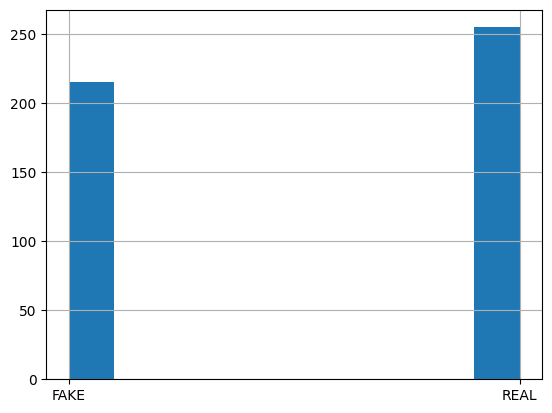

In [21]:
test_data['label'].hist()

In [22]:
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))

Train set size: 3975
Test set size: 470


In [23]:
train_data.to_csv("train_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

In [24]:
def create_json_from_csv(input_csv: str, output_json: str) -> None:
    df = pd.read_csv(input_csv)
    result: Dict[str, str] = {}

    for _, row in df.iterrows():
        file_path = row['video_path']
        label = row['label']

        result[file_path] = {'label': label}

    with open(output_json, 'w') as json_file:
        json.dump(result, json_file, indent=4)


create_json_from_csv('train_dataset.csv', 'output_balenced_train.json')
create_json_from_csv('test_dataset.csv', 'output_balenced_test.json')

In [25]:
with open('output_balenced_train.json', 'r') as json_file:
    data = json.load(json_file)

label_counts = Counter()

for item in data.values():
    label_counts[item['label']] += 1

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: FAKE, Count: 1945
Label: REAL, Count: 2030


In [26]:
from torchvision import transforms


class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, n_frames: int, df_path: str, device, cache_folder: str, image_size=(224, 224), transform=None):

        self.n_frames = n_frames
        self.videos = []
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.image_size = image_size
        
        self.transform = transform
        
        self.detector = MTCNN(device=device, post_process=False)

        with open(df_path) as f:
            videos = json.load(f)
            videos = [(video, metadata) for (video, metadata) in videos.items()]
            self.videos += videos

    def __getitem__(self, n):
        video, metadata = self.videos[n]
        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Загальна кількість кадрів у відео
        start_frame = random.randint(0, max(0, total_frames - self.n_frames))  # Випадковий стартовий кадр

        # Перемотка до стартового кадру
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        frames = []

        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resize = (self.image_size[0], self.image_size[1])
            frame = cv2.resize(frame, resize)
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame)

        cap.release()

        frames = torch.stack(frames).to(self.device)
        
        if self.transform:
            frames = self.transform(frames)

        label = 0.0
        if metadata['label'] == 'FAKE':
            label = 1.0

        return frames, torch.FloatTensor([label]).to(self.device)


    def __len__(self):
        return len(self.videos)

    
class SameAugmentation:
    def __init__(self, augmentations):
        """
        Args:
            augmentations (callable): Трансформації, що застосовуються до всіх кадрів.
        """
        self.augmentations = augmentations

    def __call__(self, frames):
        # Ініціалізуємо однакове перетворення
        seed = torch.randint(0, 2**32, (1,)).item()

        # Застосовуємо однакові трансформації до всіх кадрів
        augmented_frames = []
        for frame in frames:
            torch.manual_seed(seed)  # Встановлюємо однаковий seed
            augmented_frames.append(self.augmentations(frame))
        
        return torch.stack(augmented_frames)

Label: tensor([1.], device='cuda:0')


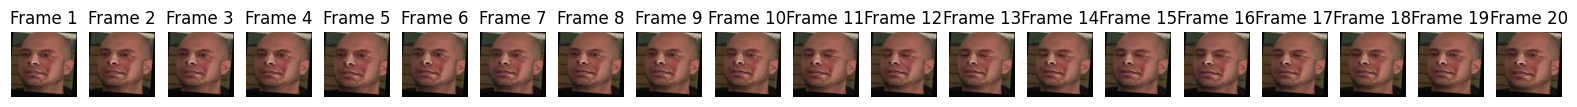

In [27]:
def test_train_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transfor = SameAugmentation(
        transforms.Compose([
            # Горизонтальне відображення
            transforms.RandomHorizontalFlip(p=0.5),
            # Легке афінне перетворення
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            # Легкий поворот
            transforms.RandomRotation(degrees=5, fill=0),
            # Розмиття для імітації відео низької якості
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            # Колірні зміни (яскравість, контраст)
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            # Перетворення в сірий для певного шуму
            transforms.RandomGrayscale(p=0.1),
        ])
    )
    
    dataset = VideoDataset(20, 'output_balenced_train.json', device, 'cache', (224, 224), transfor)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_train_data()

Label: tensor([1.], device='cuda:0')


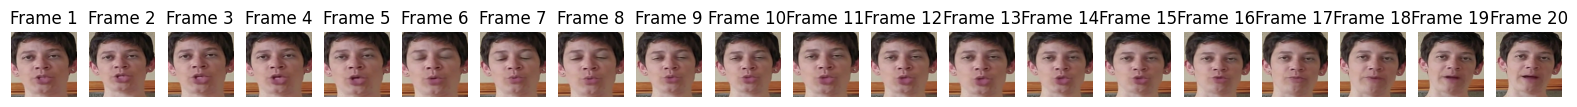

In [28]:
def test_test_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = VideoDataset(20, 'output_balenced_test.json', device, 'cache', (224, 224), None)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_test_data()

In [33]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    minposs = val_losses.index(min(val_losses)) 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [34]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [42]:
def train_model(model, hparms: dict[str, Union[int, float]], path_train: str, path_test: str, size: tuple[int], device, name: str, checkpoint_path: str = None):
    batch_size = hparms['batch_size']
    num_epochs = hparms['num_epochs']
    n_frames = hparms['n_frames']
    lr = hparms['lr']

    gamma = hparms['gamma']
    milestones = hparms['milestones']

    model.to(device)
    
    early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.0001, path=f'early_stopping_{name}_lstm_checkpoint.pt')

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    
    transfor_train = SameAugmentation(
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomRotation(degrees=5, fill=0),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            transforms.RandomGrayscale(p=0.1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    )
    
    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    train_dataset = VideoDataset(n_frames, path_train, device, 'cache', size, transfor_train)
    test_dataset = VideoDataset(n_frames, path_test, device, 'cache', size, transfor)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    start_time = datetime.datetime.now()
    print(f'Start time: {start_time}, using device: {device}')

    best_loss = np.inf
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        epoch_t_loss, epoch_v_loss = 0, 0
        t_count, t_count_wrong = 0, 0
        all_train_labels, all_train_preds = [], []
        test_probs = []

        model.train()

        for video_data, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(video_data)
            
            loss = criterion(output, labels)

            epoch_t_loss += loss.item()
            output = torch.sigmoid(output).round()
            n_wrong = (labels - output).abs().sum().item()
            t_count_wrong += n_wrong
            t_count += labels.shape[0]

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_preds.extend(output.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()

        train_loss = epoch_t_loss / len(train_loader)
        train_accuracy = (t_count - t_count_wrong) / t_count
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for video_data, labels in tqdm(val_loader, desc="Validation", leave=False):
                video_data, labels = video_data.to(device), labels.to(device)

                output = model(video_data)
                output_probs = torch.sigmoid(output)
                test_probs.extend(output_probs.cpu().numpy())
                
                loss = criterion(output, labels)
                epoch_v_loss += loss.item()

                output = torch.sigmoid(output).round()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(output.cpu().numpy())

        val_loss = epoch_v_loss / len(val_loader)
        val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_exec_time = time.time() - epoch_start_time
        epoch_times.append(epoch_exec_time)
        print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Time: {epoch_exec_time:.2f}s')
        val_auc = roc_auc_score(all_val_labels, test_probs)
        print(f'Validation AUC: {val_auc}')
        
        scheduler.step()

        torch.save({
                    'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'scheduler_state_dict': scheduler.state_dict(),
                      'epoch': epoch + 1
                      }, f'best_{name}_lstm_checkpoint_epoch_{epoch + 1}.pt'
        )
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f'Training completed in: {str(datetime.datetime.now() - start_time)}')

    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("Train Classification Report:")
    print(classification_report(all_train_labels, all_train_preds))
    plot_confusion_matrix_final(all_train_labels, all_train_preds, 'Train')

    print("Validation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Validation')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Validation AUC: {val_auc}')

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            groups=32,
            width_per_group=4
        )
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()


class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attention_weights = self.dropout(attention_weights)

        attended_values = torch.bmm(attention_weights, value)
        return attended_values


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResNetLSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim, num_lstm_layers,
                 dropout, bidirectional, freeze):
        super(ResNetLSTMClassifier, self).__init__()

        self.cnn = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.feature_output_size = 1536

        if freeze:
            self.freeze_until("layer4.0.conv1.weight")

        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],
        )

        self.lstm = nn.LSTM(
            input_size=self.feature_output_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            dropout=0.1,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * (2 if bidirectional else 1), lstm_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim // 2, 1),
        )

        self.target_layer1 = self.feature_extractor[-2][-1][0]

        self.activations = {}
        self.gradients = {}

        self.target_layer1.register_forward_hook(self.save_activations_hook("layer1"))
        self.target_layer1.register_backward_hook(self.save_gradients_hook("layer1"))

    def save_activations_hook(self, layer_name):
        def hook(module, input, output):
            self.activations[layer_name] = output
        return hook

    def save_gradients_hook(self, layer_name):
        def hook(module, grad_input, grad_output):
            self.gradients[layer_name] = grad_output[0]
        return hook

    def freeze_until(self, param_name):
        found = False
        for name, param in self.cnn.named_parameters():
            if name == param_name:
                found = True
            param.requires_grad = found

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        output = self.classifier(lstm_out[:, -1, :])

        return output

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 193MB/s]


Training ResNetLSTMNoBiClassifier20x224 model:
Hyperparameters {'n_linear_hidden': 128, 'lstm_hidden_dim': 64, 'num_lstm_layers': 2, 'dropout': 0.4, 'bidirectional': False, 'freeze': False, 'n_frames': 20, 'batch_size': 4, 'lr': 1e-05, 'num_epochs': 25, 'gamma': 0.1, 'milestones': [32, 64]}
Start time: 2025-02-19 13:05:05.463030, using device: cuda


Epoch 1/25 - Train loss: 0.6927, Train accuracy: 0.5107
Validation loss: 0.6824, Validation accuracy: 0.5426, Time: 1083.79s
Validation AUC: 0.7706155950752394
Validation loss decreased (inf --> 0.682390).  Saving model ...


Epoch 2/25 - Train loss: 0.6773, Train accuracy: 0.5625
Validation loss: 0.6600, Validation accuracy: 0.6298, Time: 1082.94s
Validation AUC: 0.7839489284085727
Validation loss decreased (0.682390 --> 0.659964).  Saving model ...


Epoch 3/25 - Train loss: 0.6421, Train accuracy: 0.6815
Validation loss: 0.6112, Validation accuracy: 0.7277, Time: 1085.26s
Validation AUC: 0.8244231646146832
Validation loss decreased (0.659964 --> 0.611218).  Saving model ...


Epoch 4/25 - Train loss: 0.5918, Train accuracy: 0.7306
Validation loss: 0.5537, Validation accuracy: 0.7660, Time: 1083.76s
Validation AUC: 0.8469858641130872
Validation loss decreased (0.611218 --> 0.553669).  Saving model ...


Epoch 5/25 - Train loss: 0.5376, Train accuracy: 0.7738
Validation loss: 0.4773, Validation accuracy: 0.8404, Time: 1086.18s
Validation AUC: 0.8989512083903328
Validation loss decreased (0.553669 --> 0.477291).  Saving model ...


Epoch 6/25 - Train loss: 0.5068, Train accuracy: 0.7877
Validation loss: 0.4816, Validation accuracy: 0.8085, Time: 1082.84s
Validation AUC: 0.8884268125854993
EarlyStopping counter: 1 out of 15


Epoch 7/25 - Train loss: 0.4876, Train accuracy: 0.7940
Validation loss: 0.4368, Validation accuracy: 0.8277, Time: 1081.45s
Validation AUC: 0.9152393980848152
Validation loss decreased (0.477291 --> 0.436801).  Saving model ...


Epoch 8/25 - Train loss: 0.4486, Train accuracy: 0.8113
Validation loss: 0.4646, Validation accuracy: 0.7936, Time: 1080.79s
Validation AUC: 0.8891928864569083
EarlyStopping counter: 1 out of 15


Epoch 9/25 - Train loss: 0.4243, Train accuracy: 0.8297
Validation loss: 0.4841, Validation accuracy: 0.7787, Time: 1003.02s
Validation AUC: 0.8751846785225718
EarlyStopping counter: 2 out of 15


Epoch 10/25 - Train loss: 0.4056, Train accuracy: 0.8357
Validation loss: 0.4314, Validation accuracy: 0.8043, Time: 998.35s
Validation AUC: 0.9056817145462835
Validation loss decreased (0.436801 --> 0.431424).  Saving model ...


Epoch 11/25 - Train loss: 0.3755, Train accuracy: 0.8561
Validation loss: 0.3933, Validation accuracy: 0.8489, Time: 998.81s
Validation AUC: 0.9106064751481988
Validation loss decreased (0.431424 --> 0.393327).  Saving model ...


Epoch 12/25 - Train loss: 0.3722, Train accuracy: 0.8523
Validation loss: 0.4460, Validation accuracy: 0.7957, Time: 1029.97s
Validation AUC: 0.900045599635203
EarlyStopping counter: 1 out of 15


Epoch 13/25 - Train loss: 0.3497, Train accuracy: 0.8672
Validation loss: 0.4557, Validation accuracy: 0.7936, Time: 1056.47s
Validation AUC: 0.8978932968536252
EarlyStopping counter: 2 out of 15


Epoch 14/25 - Train loss: 0.3254, Train accuracy: 0.8767
Validation loss: 0.4142, Validation accuracy: 0.8128, Time: 1066.29s
Validation AUC: 0.9150752393980848
EarlyStopping counter: 3 out of 15


Epoch 15/25 - Train loss: 0.3188, Train accuracy: 0.8709
Validation loss: 0.4439, Validation accuracy: 0.8106, Time: 1064.05s
Validation AUC: 0.9044231646146831
EarlyStopping counter: 4 out of 15


Epoch 16/25 - Train loss: 0.2763, Train accuracy: 0.8966
Validation loss: 0.4678, Validation accuracy: 0.7872, Time: 1056.78s
Validation AUC: 0.909858641130871
EarlyStopping counter: 5 out of 15


Epoch 17/25 - Train loss: 0.2679, Train accuracy: 0.9026
Validation loss: 0.4323, Validation accuracy: 0.8149, Time: 1001.54s
Validation AUC: 0.9009940720474235
EarlyStopping counter: 6 out of 15


Epoch 18/25 - Train loss: 0.2579, Train accuracy: 0.9001
Validation loss: 0.3785, Validation accuracy: 0.8319, Time: 994.90s
Validation AUC: 0.9232649338805289
Validation loss decreased (0.393327 --> 0.378539).  Saving model ...


Epoch 19/25 - Train loss: 0.2458, Train accuracy: 0.9109
Validation loss: 0.4514, Validation accuracy: 0.8085, Time: 994.75s
Validation AUC: 0.9106794345645234
EarlyStopping counter: 1 out of 15


Epoch 20/25 - Train loss: 0.2308, Train accuracy: 0.9182
Validation loss: 0.5054, Validation accuracy: 0.7872, Time: 995.23s
Validation AUC: 0.9284450524395805
EarlyStopping counter: 2 out of 15


Epoch 21/25 - Train loss: 0.2242, Train accuracy: 0.9155
Validation loss: 0.4089, Validation accuracy: 0.8255, Time: 994.66s
Validation AUC: 0.9347742818057456
EarlyStopping counter: 3 out of 15


Epoch 22/25 - Train loss: 0.2188, Train accuracy: 0.9218
Validation loss: 0.4579, Validation accuracy: 0.8000, Time: 991.27s
Validation AUC: 0.9091290469676243
EarlyStopping counter: 4 out of 15


Epoch 23/25 - Train loss: 0.2000, Train accuracy: 0.9258
Validation loss: 0.4979, Validation accuracy: 0.7872, Time: 992.44s
Validation AUC: 0.9353761969904241
EarlyStopping counter: 5 out of 15


Epoch 24/25 - Train loss: 0.1838, Train accuracy: 0.9356
Validation loss: 0.4031, Validation accuracy: 0.8277, Time: 987.25s
Validation AUC: 0.9349384404924761
EarlyStopping counter: 6 out of 15


Epoch 25/25 - Train loss: 0.1906, Train accuracy: 0.9328
Validation loss: 0.6408, Validation accuracy: 0.7447, Time: 988.16s
Validation AUC: 0.9248518011855905
EarlyStopping counter: 7 out of 15
Training completed in: 7:11:31.329291


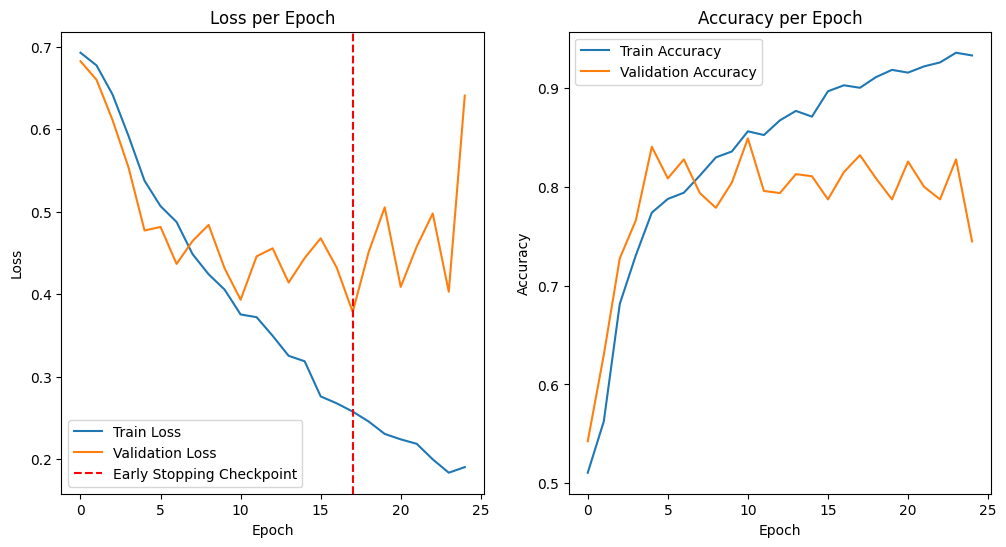

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      2030
         1.0       0.93      0.94      0.93      1945

    accuracy                           0.93      3975
   macro avg       0.93      0.93      0.93      3975
weighted avg       0.93      0.93      0.93      3975



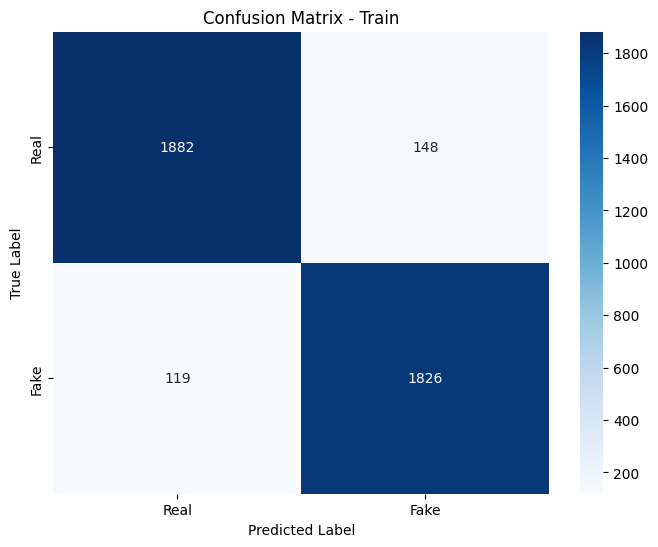

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.55      0.70       255
         1.0       0.65      0.98      0.78       215

    accuracy                           0.74       470
   macro avg       0.81      0.76      0.74       470
weighted avg       0.82      0.74      0.74       470



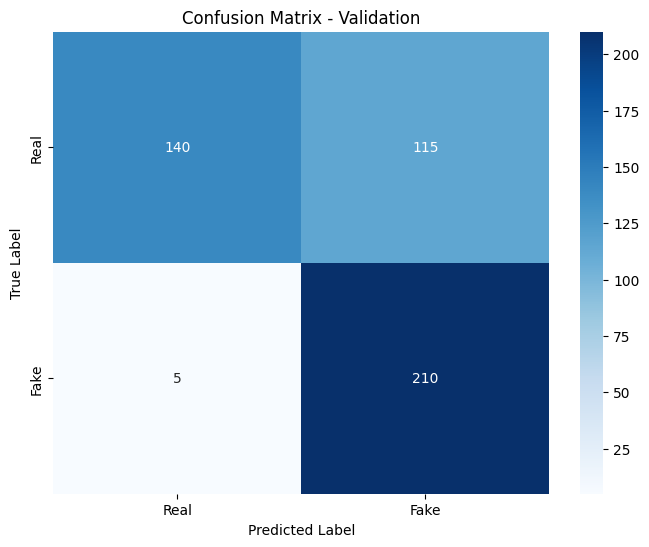

Validation AUC: 0.9248518011855905


In [46]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 128,
    'lstm_hidden_dim': 64,
    'num_lstm_layers': 2,
    'dropout': 0.4,
    'bidirectional': False,
    'freeze': False,
    'n_frames': 20,
    'batch_size': 4,
    'lr': 0.00001,
    'num_epochs': 25,
    'gamma': 0.1,
    'milestones': [32, 64]
}

models_to_train = [
    (ResNetLSTMClassifier, 'ResNetLSTMNoBiClassifier20x224', (224, 224), hyperparameters_1)
]

for model_type, name, size, hyperparameters in models_to_train:
    model = model_type(
        n_linear_hidden=hyperparameters['n_linear_hidden'],
        lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
        num_lstm_layers=hyperparameters['num_lstm_layers'],
        dropout=hyperparameters['dropout'],
        bidirectional=hyperparameters['bidirectional'],
        freeze=hyperparameters['freeze']
    )

    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_test.json', size, device, name)
    del model